# Generative models - variational auto-encoders

### Author: Philippe Esling (esling@ircam.fr)

In this course we will cover
1. A [quick recap](#recap) on simple probability concepts
2. A formal introduction to [Variational Auto-Encoders](#vae) (VAEs)
3. An explanation of the [implementation](#implem) of VAEs
4. Some [modifications and tips to improve the reconstruction](#improve) of VAEs **(exercise)**

<a id="recap"> </a>

## Quick recap on probability

The field of probability aims to model random or uncertain events. Hence, a random variable $X$ denotes a quantity that is uncertain, such as the result of an experiment (flipping a coin) or the measurement of an uncertain property (measuring the temperature). If we observe several occurrences of the variable $\{\mathbf{x}_{i}\}_{i=1}$, it might take different values on each occasion, but some values may occur more often than others. This information is captured by the _probability distribution_ $p(\mathbf{x})$ of the random variable.

To understand these concepts graphically, we will rely on the `Pytorch Probability` package.

In [1]:
import torch
import torch.nn as nn
import torch.distributions as distrib
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from helper_plot import hdr_plot_style
hdr_plot_style()

### Probability distributions

#### Discrete distributions

Let $\mathbf{x}$ be a discrete random variable with range $R_{X}=\{x_1,\cdots,x_n\}$ (finite or countably infinite). The function
\begin{equation}
    p_{X}(x_{i})=p(X=x_{i}), \forall i\in\{1,\cdots,n\}
\end{equation}
is called the probability mass function (PMF) of $X$.

Hence, the PMF defines the probabilities of all possible values for a random variable. The above notation allows to express that the PMF is defined for the random variable $X$, so that $p_{X}(1)$ gives the probability that $X=1$. For discrete random variables, the PMF is also called the \textit{probability distribution}. The PMF is a probability measure, therefore it satisfies all the corresponding properties
- $0 \leq p_{X}(x_i) < 1, \forall x_i$
- $\sum_{x_i\in R_{X}} p_{X}(x_i) = 1$
- $\forall A \subset R_{X}, p(X \in A)=\sum_{x_a \in A}p_{X}(x_a)$

A very simple example of discrete distribution is the `Bernoulli` distribution. With this distribution, we can model a coin flip. If we throw the coin a very large number of times, we hope to see on average an equal amount of _heads_ and _tails_.

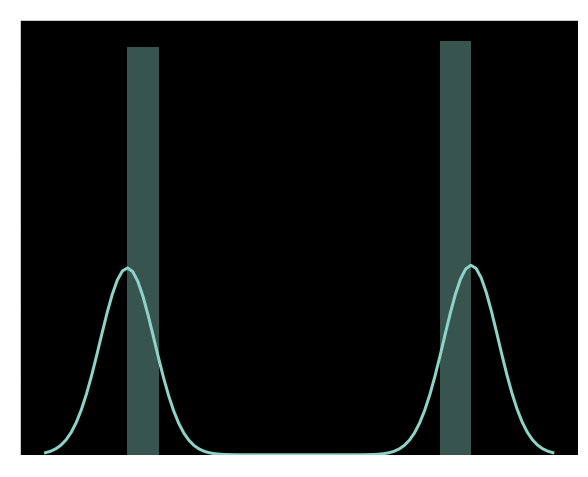

In [2]:
bernoulli = distrib.Bernoulli(0.5)
samples = bernoulli.sample((10000,))
plt.figure(figsize=(10,8))
sns.distplot(samples)
plt.title("Samples from a Bernoulli (coin toss)")
plt.show()

However, we can also _sample_ from the distribution to have individual values of a single throw. In that case, we obtain a series of separate events that _follow_ the distribution 

In [3]:
vals = ['heads', 'tails']
samples = bernoulli.sample((10,))
for s in samples:
    print('Coin is tossed on ' + vals[int(s)])

Coin is tossed on heads
Coin is tossed on heads
Coin is tossed on heads
Coin is tossed on tails
Coin is tossed on heads
Coin is tossed on heads
Coin is tossed on heads
Coin is tossed on tails
Coin is tossed on heads
Coin is tossed on heads


#### Continuous distributions

The same ideas apply to _continuous_ random variables, which can model for instance the height of human beings. If we try to guess the height of someone that we do not know, there is a higher probability that this person will be around 1m70, instead of 20cm or 3m. For the rest of this course, we will use the shorthand notation $p(\mathbf{x})$ for the distribution $p(\mathbf{x}=x_{i})$,  which expresses for a real-valued random variable $\mathbf{x}$, evaluated at $x_{i}$, the probability that $\mathbf{x}$ takes the value $x_i$.

One notorious example of such distributions is the Gaussian (or Normal) distribution, which is defined as 
\begin{equation}
    p(x)=\mathcal{N}(\mu,\sigma)=\frac{1}{\sqrt{2\pi\sigma^{2}}}e^{-\frac{(x-\mu)^{2}}{2\sigma^{2}}}
\end{equation}

Similarly as before, we can observe the behavior of this distribution with the following code

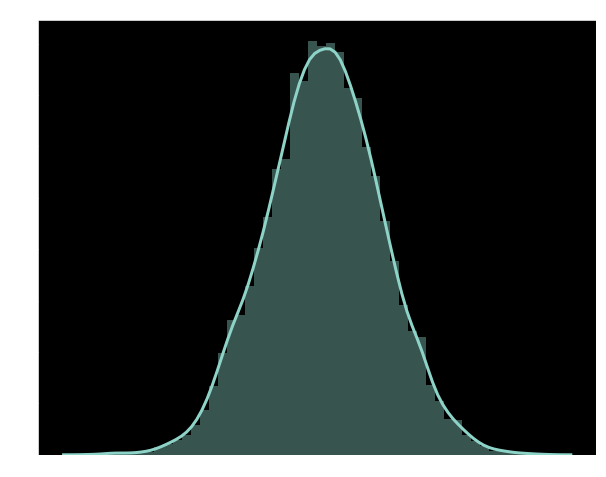

In [4]:
normal = distrib.Normal(loc=0., scale=1.)
samples = normal.sample((10000,))
plt.figure(figsize=(10,8))
sns.distplot(samples)
plt.title("Samples from a standard Normal")
plt.show()

### Comparing distributions (KL divergence)
$
\newcommand{\R}{\mathbb{R}}
\newcommand{\bb}[1]{\mathbf{#1}}
\newcommand{\bx}{\bb{x}}
\newcommand{\by}{\bb{y}}
\newcommand{\bz}{\bb{z}}
\newcommand{\KL}[2]{\mathcal{D}_{\text{KL}}\left[#1 \| #2\right]}$
Originally defined in the field of information theory, the _Kullback-Leibler (KL) divergence_ (usually noted $\KL{p(\bx)}{q(\bx)}$) is a dissimilarity measure between two probability distributions $p(\bx)$ and $q(\bx)$. In the view of information theory, it can be understood as the cost in number of bits necessary for coding samples from $p(\bx)$ by using a code optimized for $q(\bx)$ rather than the code optimized for $p(\bx)$. In the view of probability theory, it represents the amount of information lost when we use $q(\bx)$ to approximate the true distribution $p(\bx)$. %that explicit the cost incurred if events were generated by $p(\bx)$ but charged under $q(\bx)$


Given two probability distributions $p(\bx)$ and $q(\bx)$, the Kullback-Leibler divergence of $q(\bx)$ _from_ $p(\bx)$ is defined to be
\begin{equation}
    \KL{p(\bx)}{q(\bx)}=\int_{\R} p(\bx) \log \frac{p(\bx)}{q(\bx)}d\bx
\end{equation}

Note that this dissimilarity measure is \textit{asymmetric}, therefore, we have
\begin{equation}
    \KL{p(\bx)}{q(\bx)}\neq \KL{q(\bx)}{p(\bx)}
\end{equation}
This asymmetry also describes an interesting behavior of the KL divergence, depending on the order to which it is evaluated. The KL divergence can either be a _mode-seeking_ or _mode-coverage} measure.

<a id="vae"></a>
## Variational auto-encoders

As we have seen in the previous AE course, VAEs are also a form generative models. However, they are defined from a more sound probabilistic perspective. to find the underlying probability distribution of the data $p(\mathbf{x})$ based on a set of examples in $\mathbf{x}\in\mathbb{R}^{d_{x}}$. To do so, we consider *latent variables* defined in a lower-dimensional space $\mathbf{z}\in\mathbb{R}^{d_{z}}$ ($d_{z} \ll d_{x}$) with the joint probability distribution $p(\mathbf{x}, \mathbf{z}) = p(\mathbf{x} \vert \mathbf{z})p(\mathbf{z})$. Unfortunately, for complex distributions this integral is too complex and cannot be found in closed form.



### Variational inference

The idea of *variational inference* (VI) allows to solve this problem through *optimization* by assuming a simpler approximate distribution $q_{\phi}(\mathbf{z}\vert\mathbf{x})\in\mathcal{Q}$ from a family $\mathcal{Q}$ of approximate densities. Hence, the goal is to minimize the difference between this approximation and the real distribution. Therefore, this turns into the optimization problem of minimizing the Kullback-Leibler (KL) divergence between the parametric approximation and the original density

$$
q_{\phi}^{*}(\mathbf{z}\vert \mathbf{x})=\text{argmin}_{q_{\phi}(\mathbf{z} \vert \mathbf{x})\in\mathcal{Q}} \mathcal{D}_{KL} \big[ q_{\phi}\left(\mathbf{z} \vert \mathbf{x}\right) \parallel p\left(\mathbf{z} \vert \mathbf{x}\right) \big]
\tag{2}
$$

By developing this KL divergence and re-arranging terms (the detailed development can be found in [3](#reference1)), we obtain

$$
\log{p(\mathbf{x})} - D_{KL} \big[ q_{\phi}(\mathbf{z} \vert \mathbf{x}) \parallel p(\mathbf{z} \vert \mathbf{x}) \big] =
\mathbb{E}_{\mathbf{z}} \big[ \log{p(\mathbf{x} \vert \mathbf{z})}\big] - D_{KL} \big[ q_{\phi}(\mathbf{z} \vert \mathbf{x}) \parallel p(\mathbf{z}) \big]
\tag{3}
$$

This formulation describes the quantity we want to maximize $\log p(\mathbf{x})$ minus the error we make by using an approximate $q$ instead of $p$. Therefore, we can optimize this alternative objective, called the *evidence lower bound* (ELBO)

$$
\begin{equation}
\mathcal{L}_{\theta, \phi} = \mathbb{E} \big[ \log{ p_\theta (\mathbf{x|z}) } \big] - \beta \cdot D_{KL} \big[ q_\phi(\mathbf{z|x}) \parallel p_\theta(\mathbf{z}) \big]
\end{equation}
\tag{4}
$$

We can see that this equation involves $q_{\phi}(\mathbf{z} \vert \mathbf{x})$ which *encodes* the data $\mathbf{x}$ into the latent representation $\mathbf{z}$ and a *decoder* $p(\mathbf{x} \vert \mathbf{z})$, which allows generating a data vector $\mathbf{x}$ given a latent configuration $\mathbf{z}$. Hence, this structure defines the *Variational Auto-Encoder* (VAE).

The VAE objective can be interpreted intuitively. The first term  increases the likelihood of the data generated given a configuration of the latent, which amounts to minimize the *reconstruction error*. The second term represents the error made by using a simpler posterior distribution $q_{\phi}(\mathbf{z} \vert \mathbf{x})$ compared to the true prior $p_{\theta}(\mathbf{z})$. Therefore, this *regularizes* the choice of approximation $q$ so that it remains close to the true posterior distribution [3].

### Reparametrization trick

Now, while this formulation has some very interesting properties, it involves sampling operations, where we need to draw the latent point $\mathbf{z}$ from the distribution $q_{\phi}(\mathbf{z}\vert\mathbf{x})$.  The simplest choice for this variational approximate posterior is a multivariate Gaussian with a diagonal covariance structure (which leads to independent Gaussians on every dimension, called the *mean-field* family) so that
$$
\text{log}q_\phi(\mathbf{z}\vert\mathbf{x}) = \text{log}\mathcal{N}(\mathbf{z};\mathbf{\mu}^{(i)},\mathbf{\sigma}^{(i)})
\tag{5}
$$
where the mean $\mathbf{\mu}^{(i)}$ and standard deviation $\mathbf{\sigma}^{(i)}$ of the approximate posterior are different for each input point and are produced by our encoder parametrized by its variational parameters $\phi$. Now the KL divergence between this distribution and a simple prior $\mathcal{N}(\mathbf{0}, \mathbf{I})$ can be very simply obtained with
$$
D_{KL} \big[ q_\phi(\mathbf{z|x}) \parallel \mathcal{N}(\mathbf{0}, \mathbf{I}) \big] = \frac{1}{2}\sum_{j=1}^{D}\left(1+\text{log}((\sigma^{(i)}_j)^2)+(\mu^{(i)}_j)^2+(\sigma^{(i)}_j)^2\right)
\tag{6}
$$

While this looks convenient, we will still have to perform gradient descent through a sampling operation, which is non-differentiable. To solve this issue, we can use the *reparametrization trick*, which takes the sampling operation outside of the gradient flow by considering $\mathbf{z}^{(i)}=\mathbf{\mu}^{(i)}+\mathbf{\sigma}^{(i)}\odot\mathbf{\epsilon}^{(l)}$ with $\mathbf{\epsilon}^{(l)}\sim\mathcal{N}(\mathbf{0}, \mathbf{I})$

<a id="implem"> </a>

## VAE implementation

As we have seen, VAEs can be simply implemented by decomposing the above series of operations into an `encoder` which represents the distribution $q_\phi(\mathbf{z}\vert\mathbf{x})$, from which we will sample some values $\tilde{\mathbf{z}}$ (using the reparametrization trick) and compute the Kullback-Leibler (KL) divergence. Then, we use these values as input to a `decoder` which represents the distribution $p_\theta(\mathbf{x}\vert\mathbf{z})$ so that we can produce a reconstruction $\tilde{\mathbf{x}}$ and compute the reconstruction error. 

Therefore, we can define the VAE based on our previous implementation of the AE that we recall here

In [5]:
class AE(nn.Module):
    def __init__(self, encoder, decoder, encoding_dim):
        super(AE, self).__init__()
        self.encoding_dims = encoding_dim
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In order to move to a probabilistic version, we need to add the latent space sampling mechanism, and change the behavior of our `call` function. This process is implemented in the following `VAE` class.

Note that we purposedly rely on an implementation of the `encode` function where the `encoder` first produces an intermediate representation of size `encoder_dims`. Then, this representation goes through two separate functions for encoding $\mathbf{\mu}$ and $\mathbf{\sigma}$. This provides a clearer implementation but also the added bonus that we can ensure that $\mathbf{\sigma} > 0$

In [6]:
class VAE(AE):
    
    def __init__(self, encoder, decoder, encoding_dims, latent_dims):
        super(VAE, self).__init__(encoder, decoder, encoding_dims)
        self.latent_dims = latent_dims
        self.mu = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims), nn.ReLU())
        self.sigma = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims), nn.Softplus())
        
    def encode(self, x):
        
        ######################
        # YOUR CODE GOES HERE
        ######################
    
        ######################
        # Solution
        x = self.encoder(x)
        mu = self.mu(x)
        sigma = self.sigma(x)
        ######################
        
        return mu, sigma
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Encode the inputs
        z_params = self.encode(x)
        # Obtain latent samples and latent loss
        z_tilde, kl_div = self.latent(x, z_params)
        # Decode the samples
        x_tilde = self.decode(z_tilde)
        return x_tilde.reshape(-1, 1, 28, 28), kl_div
    
    def latent(self, x, z_params):
        
        ######################
        # YOUR CODE GOES HERE
        ######################
    
        ######################
        # Solution
        n_batch = x.shape[0]
        # Retrieve mean and var
        mu, sigma = z_params
        # Re-parametrize
        q = distrib.Normal(torch.zeros(mu.shape[1]), torch.ones(sigma.shape[1]))
        z = (sigma * q.sample((int(n_batch), ))) + mu
        # Compute KL divergence
        kl_div = 0.5 * torch.sum(1 + sigma - torch.pow(mu, 2) - torch.exp(sigma))
        kl_div = kl_div / n_batch
        ######################
        
        return z, kl_div

Now the interesting aspect of VAEs is that we can define any parametric function as `encoder` and `decoder`, as long as we can optimize them. Here, we will rely on simple feed-forward neural networks, but these can be largely more complex (with limitations that we will discuss later in the tutorial).

In [7]:
def construct_encoder_decoder(nin, n_latent = 16, n_hidden = 512, n_classes = 1):
    # Encoder network
    encoder = nn.Sequential(
          nn.Flatten(),
          nn.Linear(nin, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
    )
    # Decoder network
    decoder = nn.Sequential(
          nn.Linear(n_latent, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, nin * n_classes), nn.Sigmoid()
    )
    return encoder, decoder

### Evaluating the error

In the definition of the `VAE` class, we directly included the computation of the $D_{KL}$ term to regularize our latent space. However, remember that the complete loss of equation (4) also contains a *reconstruction loss* which compares our reconstructed output to the original data. 

While there are several options to compare the error between two elements, there are usually two preferred choices among the generative literature depending on how we consider our problem
1. If we consider each dimension (pixel) to be a binary unit (following a Bernoulli distribution), we can rely on the `binary cross entropy` between the two distributions
2. If we turn our problem to a set of classifications, where each dimension can belong to a given set of *intensity classes*, then we can compute the `multinomial loss` between the two distributions

In the following, we define both error functions and regroup them in the `reconstruction_loss` call (depending on the `num_classes` considered). However, as the `multinomial loss` requires a large computational overhead, and for the sake of simplicity, we will train all our first models by relying on the `binary cross entropy`

In [8]:
# Reconstruction criterion
recons_criterion = torch.nn.MSELoss(reduction='sum')

def compute_loss(model, x):
        
    ######################
    # YOUR CODE GOES HERE
    ######################
    
    ######################
    # Solution
    x_tilde, kl_div = model(x)
    cross_ent = recons_criterion(x_tilde, x)
    logpx_z = cross_ent
    full_loss = torch.mean(logpx_z - kl_div)
    ######################
    return full_loss

def train_step(model, x, optimizer):
    # Compute the loss.
    loss = compute_loss(model, x)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    return loss

### Optimizing a VAE on a real dataset

For this tutorial, we are going to take a quick shot at a real-life problem by trying to train our VAEs on the `FashionMNIST` dataset. This dataset can be natively used in PyTorch by relying on the `torchvision.datasets` classes as follows

In [9]:
dataset_dir = './data'
# Going to use 80%/20% split for train/valid
valid_ratio = 0.2
# Load the dataset for the training/validation sets
train_valid_dataset = torchvision.datasets.FashionMNIST(root=dataset_dir, train=True, transform=torchvision.transforms.ToTensor(), download=True)
# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])
# Load the test set
test_dataset = torchvision.datasets.FashionMNIST(root=dataset_dir, transform=torchvision.transforms.ToTensor(),train=False)
# Prepare 
num_threads = 4     # Loading the dataset is using 4 CPU threads
batch_size  = 128   # Using minibatches of 128 samples
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_threads)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,num_workers=num_threads)

The `FashionMNIST` dataset is composed of simple 28x28 black and white images of different items of clothings (such as shoes, bags, pants and shirts). We put a simple function here to display one batch of the test set (note that we keep a fixed batch from the test set in order to evaluate the different variations that we will try in this tutorial).

The train set contains 48000 images, in 375 batches
The validation set contains 12000 images, in 94 batches
The test set contains 10000 images, in 79 batches


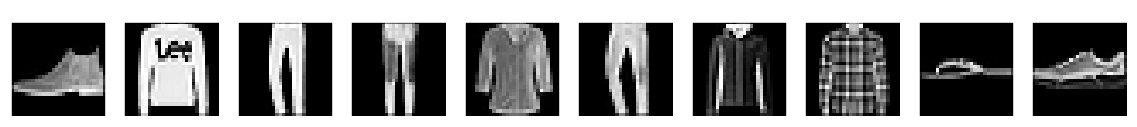

In [10]:
print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The validation set contains {} images, in {} batches".format(len(valid_loader.dataset), len(valid_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))
nsamples = 10
classes_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal','Shirt', 'Sneaker', 'Bag', 'Ankle boot']
imgs_test, labels = next(iter(test_loader))
fig = plt.figure(figsize=(20,5))
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs_test[i, 0, :, :], vmin=0, vmax=1.0, cmap=matplotlib.cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Now based on our proposed implementation, the optimization aspects are defined in a very usual way

In [11]:
# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 512
n_latent = 8
# Compute input dimensionality
nin = imgs_test.shape[2] * imgs_test.shape[3]
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes)
# Build the VAE model
model = VAE(encoder, decoder, n_hidden, n_latent)
# Construct the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Now all that is left to do is train the model. We define here a `train_vae` function that we will reuse along the future implementations and variations of VAEs and flows. Note that this function is set to run for only a very few number of `epochs` and also most importantly, *only considers a subsample of the full dataset at each epoch*. This option is just here so that you can test the different models very quickly on any CPU or laptop.

Epoch: 1, Test set ELBO: tensor([2586797.5000], grad_fn=<AddBackward0>)


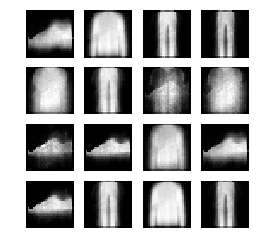

Epoch: 2, Test set ELBO: tensor([1374927.2500], grad_fn=<AddBackward0>)


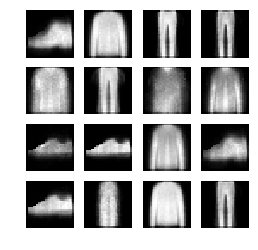

Epoch: 3, Test set ELBO: tensor([1193572.8750], grad_fn=<AddBackward0>)


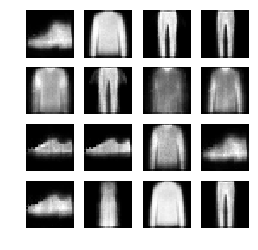

Epoch: 4, Test set ELBO: tensor([1015721.1875], grad_fn=<AddBackward0>)


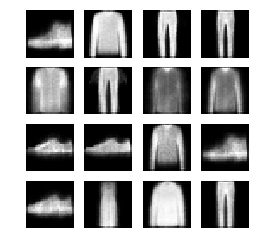

Epoch: 5, Test set ELBO: tensor([920523.7500], grad_fn=<AddBackward0>)


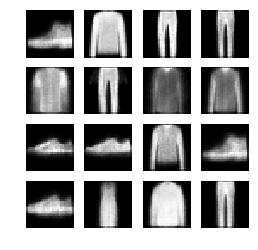

Epoch: 6, Test set ELBO: tensor([863158.4375], grad_fn=<AddBackward0>)


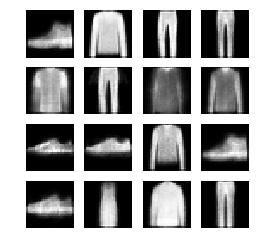

Epoch: 7, Test set ELBO: tensor([825967.7500], grad_fn=<AddBackward0>)


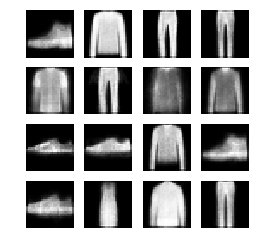

Epoch: 8, Test set ELBO: tensor([796565.3750], grad_fn=<AddBackward0>)


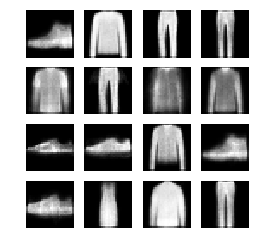

Epoch: 9, Test set ELBO: tensor([773841.6250], grad_fn=<AddBackward0>)


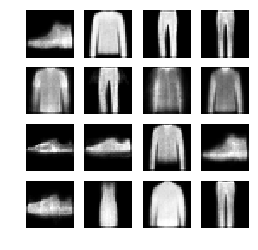

Epoch: 10, Test set ELBO: tensor([756896.5625], grad_fn=<AddBackward0>)


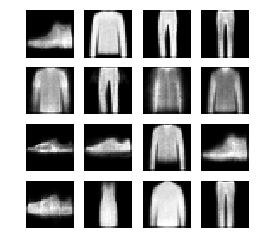

KeyboardInterrupt: 

In [12]:
def generate_and_save_images(model, epoch, test_sample):
    predictions, _ = model(test_sample)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, 0, :, :].detach(), cmap='gray')
        plt.axis('off')
    # Tight_layout minimizes the overlap between 2 sub-plots
    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

epochs=50
test_sample = imgs_test[0:16, :, :, :]
for epoch in range(1, epochs + 1):
    full_loss = torch.Tensor([0])
    # Forward pass: compute predicted y by passing x to the model.
    for i, (x, _) in enumerate(train_loader):
        full_loss += train_step(model, x, optimizer)
    #for i, (x, _) in enumerate(valid_loader):
    #    train_step(model, x, optimizer)
    print('Epoch: {}, Test set ELBO: {}'.format(epoch, full_loss))
    generate_and_save_images(model, epoch, test_sample)

### Evaluating generative models

In order to evaluate our upcoming generative models, we will rely on the computation of the Negative Log-Likelihood. This code for the following `evaluate_nll_bpd` is inspired by the [Sylvester flow repository](https://github.com/riannevdberg/sylvester-flows)

In [ ]:
from scipy.special import logsumexp

def evaluate_nll_bpd(data_loader, model, batch = 500, R = 5):
    # Set of likelihood tests
    likelihood_test = []
    # Go through dataset
    for batch_idx, (x, _) in enumerate(data_loader):
        for j in range(x.shape[0]):
            a = []
            for r in range(0, R):
                cur_x = x[j].unsqueeze(0)
                # Repeat it as batch
                x = cur_x.expand(batch, *cur_x.size()[1:]).contiguous()
                x = x.view(batch, -1)
                x_tilde, kl_div = model(x)
                rec = reconstruction_loss(x_tilde, x, average=False)
                a_tmp = (rec + kl_div)
                a.append(- a_tmp.cpu().data.numpy())
            # calculate max
            a = np.asarray(a)
            a = np.reshape(a, (a.shape[0] * a.shape[1], 1))
            likelihood_x = logsumexp(a)
            likelihood_test.append(likelihood_x - np.log(len(a)))
    likelihood_test = np.array(likelihood_test)
    nll = - np.mean(likelihood_test)
    # Compute the bits per dim (but irrelevant for binary data)
    bpd = nll / (np.prod(nin) * np.log(2.))
    return nll, bpd

Now we can evaluate our VAE model more formally as follows.

In [ ]:
# Plot final loss
plt.figure()
plt.plot(losses_kld[:, 0].numpy());
# Evaluate log-likelihood and bits per dim
nll, _ = evaluate_nll_bpd(test_loader, model)
print('Negative Log-Likelihood : ' + str(nll))

We can also evaluate the latent space of our model, which should be organized (being the overall point of using a VAE instead of a common AE).

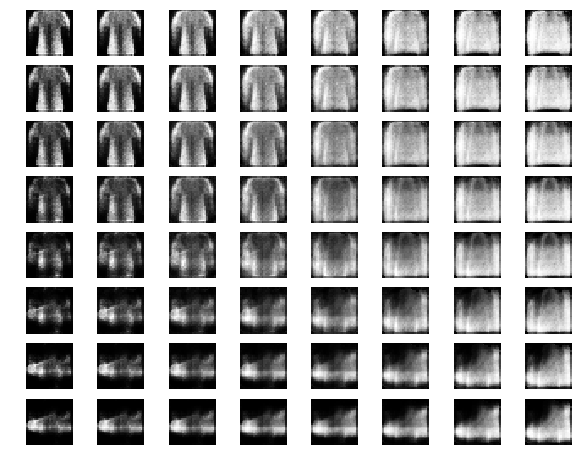

In [25]:
x = np.linspace(-3, 3, 8)
y = np.linspace(-3, 3, 8)
fig = plt.figure(figsize=(10, 8))
for i in range(8):
    for j in range(8):
        plt.subplot(8, 8, (i * 8) + j + 1)
        final_tensor = torch.zeros(n_latent)
        final_tensor[0] = x[i]
        final_tensor[3] = y[j]
        plt.imshow(model.decode(final_tensor).detach().reshape(28, 28), cmap='gray')
        plt.axis('off')

### Limitations of VAEs - (**exercise**)

Although VAEs are extremely powerful tools, they still have some limitations. Here we list the three most important and known limitations (all of them are still debated and topics of active research). 
1. **Blurry reconstructions.** As can be witnessed directly in the results of the previous vanilla VAE implementation, the reconstructions appear to be blurry. The precise origin of this phenomenon is still debated, but the proposed explanation are
    1. The use of the KL regularization
    2. High variance regions of the latent space
    3. The reconstruction criterion (expectation)
    4. The use of simplistic latent distributions
2. **Posterior collapse.** The previous *blurry reconstructions* issue can be mitigated by using a more powerful decoder. However, relying on a decoder with a large capacity causes the phenomenon of *posterior collapse* where the latent space becomes useless. A nice intuitive explanation can be found [here](https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/)
3. **Simplistic Gaussian approximation**. In the derivation of the VAE objective, recall that the KL divergence term needs to be computed analytically. Therefore, this forces us to rely on quite simplistic families. However, the Gaussian family might be too simplistic to model real world data

In the present tutorial, we show how normalizing flows can be used to mostly solve the third limitation, while also adressing the two first problems. Indeed, we will see that normalizing flows also lead to sharper reconstructions and also act on preventing posterior collapse

<a id="improve"></a>
## Improving the quality of VAEs

As we discussed in the previous section, several known issues have been reported when using the vanilla VAE implementation. We listed some of the major issues as being
1. **Blurry reconstructions.** 
2. **Posterior collapse.**
3. **Simplistic Gaussian approximation**.

Here, we discuss some recent developments that were proposed in the VAE literature and simple adjustments that can be made to (at least partly) alleviate these issues. However, note that some more advanced proposals such as PixelVAE [5](#reference1) and VQ-VAE [6](#reference1) can lead to wider increases in quality

### Reducing the bluriness of reconstructions

In this tutorial, we relied on extremely simple decoder functions, to show how we could easily define VAEs and normalizing flows together. However, the capacity of the decoder obviously directly influences the quality of the final reconstruction. Therefore, we could address this issue naively by using deep networks and of course convolutional layers as we are currently dealing with images.

First you need to construct a more complex encoder and decoder

In [65]:
def construct_encoder_decoder_complex(nin, n_latent = 16, n_hidden = 512, n_params = 0, n_classes = 1):
    # Encoder network
    encoder = ...
    # Decoder network
    decoder = ...
    return encoder, decoder

### Preventing posterior collapse with Wasserstein-VAE-MMD (InfoVAE)

As we discussed earlier, the reason behind posterior collapse mostly relates to the KL divergence criterion (a nice intuitive explanation can be found [here](https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/). This can be mitigated by relying on a different criterion, such as regularizing the latent distribution by using the *Maximum Mean Discrepancy* (MMD) instead of the KL divergence. This model was independently proposed as the *InfoVAE* and later also as the *Wasserstein-VAE*.

Here we provide a simple implementation of the `InfoVAEMMD` class based on our previous implementations.

In [66]:
def compute_kernel(x, y):
    return ...

def compute_mmd(x, y):
    return ...

class InfoVAEMMD(VAE):
    
    def __init__(self, encoder, decoder):
        super(InfoVAEMMD, self).__init__(encoder, decoder)
        
    def latent(self, x, z_params):
        return ...

### Putting it all together

Here we combine all these ideas (except for the MMD, which is not adequate as the flow definition already regularizes the latent space without the KL divergence) to perform a more advanced optimization of the dataset. Hence, we will rely on the complex encoder and decoder with gated convolutions, the multinomial loss and the normalizing flows in order to improve the overall quality of our reconstructions.

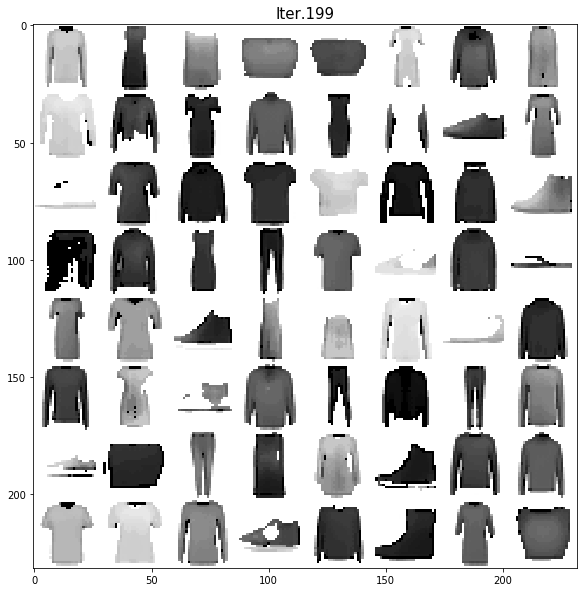

In [38]:
# Size of latent space
n_latent = 16
# Number of hidden units
n_hidden = 256
# Rely on Bernoulli or multinomial
num_classes = 128
# Construct encoder and decoder
encoder, decoder = ...
# Create VAE or (InfoVAEMMD - WAE) model
model_flow_p = ...
# Create optimizer algorithm
optimizer = ...
# Add learning rate scheduler
scheduler = ...
# Launch our optimization
losses_flow_param = ...

*NB*: It seems that the multinomial version have a hard time converging. Although I only let this run for 200 epochs and only for a subsampling of 5000 examples, it might need more time, but this might also come from a mistake somewhere in my code ... If you spot something odd please let me know :)

### References

<a id="reference1"></a>
[1] Rezende, Danilo Jimenez, and Shakir Mohamed. "Variational inference with normalizing flows." _arXiv preprint arXiv:1505.05770_ (2015). [link](http://arxiv.org/pdf/1505.05770)

[2] Kingma, Diederik P., Tim Salimans, and Max Welling. "Improving Variational Inference with Inverse Autoregressive Flow." _arXiv preprint arXiv:1606.04934_ (2016). [link](https://arxiv.org/abs/1606.04934)

[3] Kingma, D. P., & Welling, M. Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114. (2013). [link](https://arxiv.org/pdf/1312.6114)

[4] Rezende, D. J., Mohamed, S., & Wierstra, D. Stochastic backpropagation and approximate inference in deep generative models. arXiv preprint arXiv:1401.4082. (2014). [link](https://arxiv.org/pdf/1401.4082)

[5] Gulrajani, I., Kumar, K., Ahmed, F., Taiga, A. A., Visin, F., Vazquez, D., & Courville, A. (2016). Pixelvae: A latent variable model for natural images. arXiv preprint arXiv:1611.05013. [link](https://arxiv.org/pdf/1611.05013)

[6] Van den Oord, A., & Vinyals, O. (2017). Neural discrete representation learning. In NIPS 2017 (pp. 6306-6315). [link](http://papers.nips.cc/paper/7210-neural-discrete-representation-learning.pdf)

### Inspirations and resources

https://blog.evjang.com/2018/01/nf1.html  
https://github.com/ex4sperans/variational-inference-with-normalizing-flows  
https://akosiorek.github.io/ml/2018/04/03/norm_flows.html  
https://github.com/abdulfatir/normalizing-flows  
https://github.com/riannevdberg/sylvester-flows